## DTW Data generation and visualization

In [15]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0,'..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from generate_segment_trajectories import GenerateSegmentTrajectories, get_agent_ids,get_max_frame_value

In [37]:
from dtw import dtw

# Here, we use L2 norm as the element comparison distance
l2_norm = lambda x, y: np.linalg.norm((x - y))

In [45]:
# TODO
# for each round, get all agent IDs
# for each agent ID, get the segment trajectories of FRAME_LENGTH duration, for simplicity take N random durations or TotalLength%Frame_length(ie. zero overlap) - possibly optimize this to choose "interesting" segments, ie the ones which have multiple vehicles interacting
# for each agent_segment, generate a set of DTW maps
# the DTW maps will be W,H,* where * will vary across different cases, pad the * to be a max of 10, hence we have a W,H,10 tensor for each scenario. 
#    due to dtw, W = H = Frame duration

def get_dtw_maps():
    FRAME_LENGTH = 25 # how long should one unit of the scenario be/ what duration is enough to identify an anomaly
    RADIUS = 15 # how far should we look
    rounds = [0]
    max_channels = 10
    agent_map_folder="../agent_maps"

    dtw_result = []
    for round_id in rounds:
        # Todo: add logic to pick agents that are present for the longest time (currently all agents are present always)
        # also possibly sample agents? maybe we dont need all agents?
        agent_ids = get_agent_ids(agent_map_folder,round_number=round_id)
        max_frame = get_max_frame_value(agent_map_folder,round_number=round_id)
        for agent_id in agent_ids:
            # the below range function samples all non overlapping segments in the recording, can have some smart sampling here
            for start_index in range(0,max_frame,FRAME_LENGTH):
                dtw_maps = []
                if start_index+FRAME_LENGTH>max_frame:
                    continue
                gen = GenerateSegmentTrajectories(round_number=round_id, agent_id=agent_id, radius=RADIUS, start_index=start_index, frame_length=FRAME_LENGTH,agent_map_folder="../agent_maps")
                gen.generate()
                data = gen.get_trajectory_data()
                for other_agent in data["sorted_agent_ids"]:
                    if(other_agent==agent_id): continue
                    if(len(dtw_maps)==max_channels):break # since sorted_agent_ids is sorted by agent's length, we will get the N longest dtw maps
                    dist, cost_matrix, acc_cost_matrix, path = dtw(data["agent_tracks"][agent_id], data["agent_tracks"][other_agent], dist=l2_norm)
                    dtw_maps.append(np.expand_dims(acc_cost_matrix.T,axis=0))             
                # merge 10 dtw maps and make a 10,w,h tensor here and append to parent data list
                dtw_tensor = np.vstack(dtw_maps)
                if dtw_tensor.shape[0]<max_channels:
                    # padding missing channels with zeros here
                    pad_size = max_channels-dtw_tensor.shape[0]
                    pad_obj = np.zeros((pad_size,dtw_tensor.shape[1],dtw_tensor.shape[2]))
                    dtw_tensor = np.vstack([dtw_tensor,pad_obj])
                dtw_result.append(dtw_tensor)
                if(len(dtw_result)>4):
                    return dtw_result

In [48]:
# res = get_dtw_maps()
res[1].shape

(10, 25, 25)

### Playground/experiments below

In [30]:
FRAME_LENGTH = 25 # how long should one unit of the scenario be/ what duration is enough to identify an anomaly
RADIUS = 15 # how far should we look


gen = GenerateSegmentTrajectories(round_number=0, agent_id=324, radius=RADIUS, start_index=50, frame_length=FRAME_LENGTH,agent_map_folder="../agent_maps")

In [38]:
gen.generate()

data = gen.get_trajectory_data()

In [39]:
gen.generate_basic_frame_level_stats()

In [40]:
frame_wise_dfs = gen.frame_id_wise_df
basic_stats = gen.basic_frame_df

In [41]:
basic_stats

,frame_id,round_id,ego_agent_id,num_vehicles,max_velocity_x,max_velocity_y,max_velocity_z,max_ang_velocity_x,max_ang_velocity_y,max_ang_velocity_z,...,min_velocity_z,min_ang_velocity_x,min_ang_velocity_y,min_ang_velocity_z,max_acc_x,max_acc_y,max_acc_z,min_acc_x,min_acc_y,min_acc_z
0,50,0,3,324,4.626305,-0.020333,3.108460e-06,0.002033,0.009757,0.004870,...,-3.051249e-07,0.000451,-0.080103,-0.000123,0.202999,0.001129,9.535153e-07,-0.046940,-0.000768,-1.334922e-06
1,51,0,3,324,4.710058,-0.020370,8.772341e-07,0.000759,-0.028987,0.012879,...,-1.716328e-07,0.000396,-0.164853,-0.000298,0.418763,-0.000186,4.672225e-06,-0.040572,-0.000582,-1.201429e-05
2,52,0,3,324,4.777140,-0.019461,-2.288437e-07,0.004831,0.013016,0.042348,...,-1.430273e-06,-0.000393,-0.120655,0.000402,0.335412,0.004543,-5.530389e-06,-0.073071,-0.001179,-8.963044e-06
3,53,0,3,324,4.793020,-0.018174,4.195468e-07,0.005326,0.044811,0.069348,...,-9.535154e-07,0.000009,-0.023796,-0.000429,0.079401,0.006439,7.532772e-06,-0.067945,-0.000885,1.620976e-06
4,54,0,3,324,4.771416,-0.016925,-3.623358e-07,0.003271,0.161876,0.084707,...,-5.148983e-07,0.000109,-0.021185,-0.000153,-0.023708,0.006243,2.193085e-06,-0.108023,-0.000493,-4.672225e-06
5,55,0,3,324,4.750421,-0.015033,4.059325e-03,0.005236,0.145408,0.114028,...,1.907031e-08,-0.317570,-0.018135,-0.000112,0.010796,0.009457,2.029920e-02,-0.104976,-0.000264,2.669843e-06
6,56,0,3,324,4.755912,-0.013050,5.037324e-02,0.004797,1.241950,0.142359,...,8.581638e-07,-1.135468,0.007987,0.002892,0.073879,0.042891,2.315696e-01,-0.017018,0.000439,4.195468e-06
7,57,0,3,324,4.784440,-0.010949,4.087077e-02,0.868177,1.061273,0.169627,...,1.907031e-07,-0.062909,-0.049261,-0.056296,0.142639,0.050057,1.993130e-01,0.035124,-0.035870,-8.131826e-02
8,58,0,3,324,4.814078,-0.008558,9.119764e-03,0.004295,0.410429,0.198291,...,-9.725857e-07,-0.111888,-0.059334,-0.025854,0.148191,0.011958,-5.816444e-06,-0.070581,-0.035932,-1.587550e-01
9,59,0,3,324,4.826777,-0.005856,1.469615e-03,0.022676,0.129841,0.226993,...,-6.705311e-04,-0.011766,-0.005139,-0.021715,0.063498,0.013509,1.306316e-05,-0.104792,-0.008377,-4.332354e-02


In [22]:
data['sorted_agent_ids']# data['agent_metadata_dfs']

[287, 289, 324]

In [23]:
frame_wise_dfs.keys()

dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])

In [26]:
frame_wise_dfs[50]

,level_0,index,frame_id,id,type_id,pos_x,pos_y,pos_z,roll,pitch,...,angular_vel_x,angular_vel_y,angular_vel_z,bbox3d_offset_x,bbox3d_offset_y,bbox3d_offset_z,bbox3d_extent_x,bbox3d_extent_y,bbox3d_extent_z,traffic_light_color
0,70,5516,50,287,vehicle.toyota.prius,11.738648,-11.330558,0.035445,0.000015,0.033202,...,0.000451,-0.034525,0.000406,0.000000,0.0,0.710000,2.269167,1.000565,0.768681,NaN
1,72,5518,50,289,vehicle.chevrolet.impala,11.963082,-14.826639,-0.048051,0.000021,0.024548,...,0.001158,-0.080103,-0.000123,0.000000,0.0,0.710000,2.684597,1.026368,0.707550,NaN
2,107,5553,50,324,vehicle.mustang.mustang,0.000000,0.000000,-0.006685,-0.000153,0.019377,...,0.002033,0.009757,0.004870,0.060645,0.0,0.747342,2.452351,1.030329,0.739199,NaN


In [43]:
frame_wise_dfs[50].columns

Index(['level_0', 'index', 'frame_id', 'id', 'type_id', 'pos_x', 'pos_y',
       'pos_z', 'roll', 'pitch', 'yaw', 'velocity_x', 'velocity_y',
       'velocity_z', 'acc_x', 'acc_y', 'acc_z', 'angular_vel_x',
       'angular_vel_y', 'angular_vel_z', 'bbox3d_offset_x', 'bbox3d_offset_y',
       'bbox3d_offset_z', 'bbox3d_extent_x', 'bbox3d_extent_y',
       'bbox3d_extent_z', 'traffic_light_color'],
      dtype='object')

In [14]:
# for id in data['sorted_agent_ids']
data['agent_metadata_dfs'][287]
#  for each frame, get the min and max velocities, min, max acceleration, angular velocities, number of agents

,level_0,index,frame_id,id,type_id,pos_x,pos_y,pos_z,roll,pitch,...,angular_vel_x,angular_vel_y,angular_vel_z,bbox3d_offset_x,bbox3d_offset_y,bbox3d_offset_z,bbox3d_extent_x,bbox3d_extent_y,bbox3d_extent_z,traffic_light_color
0,70,5516,50,287,vehicle.toyota.prius,11.738648,-11.330558,0.035445,0.000015,0.033202,...,0.000451,-0.034525,0.000406,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
3,70,5624,51,287,vehicle.toyota.prius,10.799512,-11.339936,0.035478,0.000036,0.030087,...,0.000587,-0.029146,-0.000298,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
6,70,5732,52,287,vehicle.toyota.prius,9.851180,-11.349789,0.035506,0.000016,0.027348,...,0.000170,-0.026119,0.000474,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
9,70,5840,53,287,vehicle.toyota.prius,8.898015,-11.360060,0.035532,0.000038,0.024862,...,0.000519,-0.023796,-0.000302,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
12,70,5948,54,287,vehicle.toyota.prius,7.944973,-11.370479,0.035556,0.000028,0.022628,...,0.000207,-0.021185,0.000130,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
15,70,6056,55,287,vehicle.toyota.prius,6.993459,-11.381090,0.035576,0.000035,0.020689,...,0.000407,-0.018135,-0.000112,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
18,70,6164,56,287,vehicle.toyota.prius,6.041590,-11.391827,0.035605,-0.001617,0.019466,...,-0.098251,0.007987,0.003873,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
21,70,6272,57,287,vehicle.toyota.prius,5.086700,-11.402581,0.037241,-0.088440,0.074108,...,0.868177,1.049767,-0.056296,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
24,70,6380,58,287,vehicle.toyota.prius,4.128369,-11.412943,0.038386,-0.109650,0.120225,...,-0.111888,0.289344,-0.025854,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN
27,70,6488,59,287,vehicle.toyota.prius,3.167264,-11.423146,0.038620,-0.113770,0.136139,...,-0.011766,0.092497,-0.021715,0.0,0.0,0.71,2.269167,1.000565,0.768681,NaN


In [33]:
from dtw import dtw

# Here, we use L2 norm as the element comparison distance
l2_norm = lambda x, y: np.linalg.norm((x - y))

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

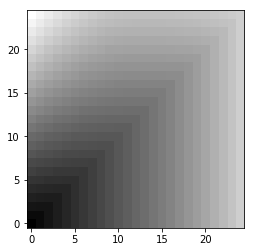

In [24]:
dist, cost_matrix, acc_cost_matrix, path = dtw(data["agent_tracks"][287], data["agent_tracks"][324], dist=l2_norm)
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
# plt.plot(path[0], path[1], 'w')
plt.show()

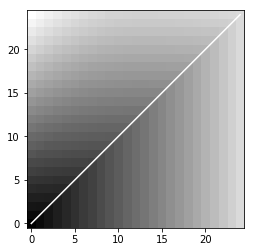

In [31]:
dist, cost_matrix, acc_cost_matrix, path = dtw(data["agent_tracks"][289], data["agent_tracks"][324], dist=l2_norm)
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

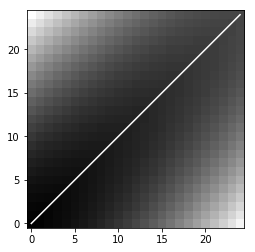

In [33]:
dist, cost_matrix, acc_cost_matrix, path = dtw(data["agent_tracks"][289], data["agent_tracks"][287], dist=l2_norm)
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [45]:
gen = GenerateSegmentTrajectories(round_number=0, agent_id=324, radius=15, start_index=290, frame_length=25,agent_map_folder="../agent_maps")

In [46]:
gen.generate()

data2 = gen.get_trajectory_data()
data2["agent_track_lens"]

{51: 10, 262: 25, 275: 25, 314: 23, 324: 25}

In [47]:
data2["sorted_agent_ids"]

[262, 275, 324, 314, 51]

In [67]:
def plot_dtw_map(agent1,agent2,data):
    l2_norm = lambda x, y: np.linalg.norm((x - y))
    dist, cost_matrix, acc_cost_matrix, path = dtw(data["agent_tracks"][agent1], data["agent_tracks"][agent2], dist=l2_norm)
    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(path[0], path[1], 'w')
    plt.show()

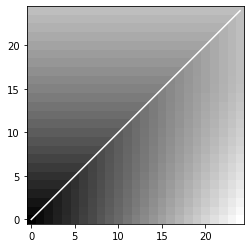

In [68]:
plot_dtw_map(324,262,data2)

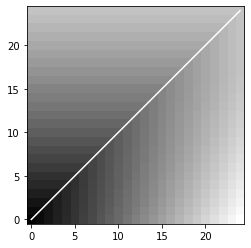

In [69]:
plot_dtw_map(324,275,data2)

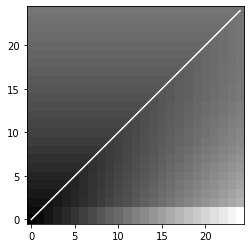

In [74]:
plot_dtw_map(324,314,data2)

In [59]:
acc_cost_matrix.shape

(25, 25)

In [ ]:
N=Number of agents in the scenario

Autoencoder
[N,25,25]->[encoder]->vector->[decoder]->[N,25,25]

Classifier
[N,25,25]->[encoder]->vector->classifier